## Prepare

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src/')

In [2]:
from package.logger import setup
setup("INFO")

In [3]:
import os

import folium

from package import strtime
from package.mcr5.h3 import (
    plot_h3_cells_on_folium,
)
from package.mcr5.labels import read_labels_for_nodes
from package.geometa import GeoMeta
from package.mcr.data import NetworkType, OSMData
import pandas as pd

In [4]:
geo_meta_path = "../data/geometa.pkl"
city_id = "Koeln"
stops = "../data/cleaned/stops.csv"
structs = "../data/structs.pkl"

geo_meta = GeoMeta.load(geo_meta_path)
geo_data = OSMData(
	geo_meta,
	city_id,
	additional_network_types=[NetworkType.DRIVING],
)
nodes = geo_data.osm_nodes
edges = geo_data.osm_edges
driving_nodes, _, _ = geo_data.additional_networks[NetworkType.DRIVING]

[12:51:33] INFO     Using existing OSM data                                                              ]8;id=407334;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py\osm.py]8;;\:]8;id=387561;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py#106\106]8;;\

           INFO     Loading OSM network from cache (walking)                                              ]8;id=837063;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py\osm.py]8;;\:]8;id=855134;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py#69\69]8;;\

[12:52:18] INFO     Using existing OSM data                                                              ]8;id=728244;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py\osm.py]8;;\:]8;id=95064;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py#106\106]8;;\

           INFO     Loading OSM network from cache (driving)                                              ]8;id=13991;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py\osm.py]8;;\:]8;id=225994;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/osm/osm.py#69\69]8;;\

## Fetch POIs

In [5]:
import matplotlib.pyplot as plt
from package.minute_city import minute_city

In [6]:
pois = minute_city.fetch_pois_for_area(geo_meta.boundary, nodes)
pois.head(3)

name         id         lat        lon  \
0        Trink & Spare  263442909  51.0268777  6.8879464   
1       Weinhaus Linke  444820559  50.9543812  6.9189388   
2  O'Donnell Moonshine  448400534  50.9382394  6.9408967   

                   geometry     type  nearest_osm_node_id   distance  
0  POINT (6.88795 51.02688)  grocery           9007727500  21.098025  
1  POINT (6.91894 50.95438)  grocery           3890235659  13.327476  
2  POINT (6.94090 50.93824)  grocery           6513219752  16.685454

## Visualize POIs

In [62]:
# def rgb2hex(rgb):
# 	return "#{:02x}{:02x}{:02x}".format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
# types = pois["type"].unique()

# types = ['grocery', 'education', 'health', 'banks', 'parks', 'sustenance', 'shops']

# # Get a colormap and create a color mapping
# colormap = plt.colormaps.get_cmap('tab10')
# color_mapping = {type_: rgb2hex(colormap(i)) for i, type_ in enumerate(types)}
# color_mapping

# bbox = nodes.unary_union.convex_hull.bounds

# m = folium.Map(location=[50.9375, 6.9603], zoom_start=12)
# geo_meta.add_to_folium_map(m)
# for _, poi in pois.iterrows():
# 	folium.CircleMarker(
# 		location=(poi.lat, poi.lon),
# 		popup=poi["name"],
# 		radius=1,
# 		color=color_mapping[poi["type"]]
# 	).add_to(m)

# m

## Calculate 15-minute-city metric

In [8]:
mcr5_output_path = "../data/mcr5/Koeln"

In [9]:
labels_per_scenario = {}
for entry in os.scandir(mcr5_output_path):
    if not entry.is_dir():
        continue

    labels = read_labels_for_nodes(
        entry.path, pois.nearest_osm_node_id.unique()
    )

    labels = minute_city.add_pois_to_labels(labels, pois)
    labels_per_scenario[entry.name] = labels


In [10]:
labels_per_scenario["car"].head(3)

target_id_osm   time  cost  n_transfers human_readable_time  \
0      215425499  29602     0            1            08:13:22   
1      215425499  29602     0            1            08:13:22   
2      215425499  28888    38            1            08:01:28   

      start_id_hex  nearest_osm_node_id  grocery  education  health  banks  \
0  891fa1983dbffff            215425499        0          1       0      0   
1  891fa1983dbffff            215425499        0          1       0      0   
2  891fa1983dbffff            215425499        0          1       0      0   

   parks  sustenance  shops  
0      0           0      0  
1      0           0      0  
2      0           0      0

In [11]:
types = list(pois["type"].unique())

In [12]:
profiles_df_per_scenario = {}
for scenario, labels in labels_per_scenario.items():
	profiles_df_per_scenario[scenario] = minute_city.get_profiles_df(labels, types)

[12:53:11] INFO     Grouping labels                                                               ]8;id=627362;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=320188;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

[12:53:12] INFO     Grouping labels done (0.22 seconds)                                           ]8;id=299931;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=300133;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=767641;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=680938;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/3590 [00:00<?, ?it/s]

[12:53:23] INFO     Calculating profiles done (11.79 seconds)                                     ]8;id=670624;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=297600;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=270876;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=286963;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

[12:53:25] INFO     Creating profiles dataframe done (1.41 seconds)                               ]8;id=595630;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=401901;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Grouping labels                                                               ]8;id=681472;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=86026;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Grouping labels done (0.10 seconds)                                           ]8;id=310951;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=405342;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=619603;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=6531;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/3590 [00:00<?, ?it/s]

[12:53:34] INFO     Calculating profiles done (8.64 seconds)                                      ]8;id=241059;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=431500;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=742658;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=73585;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

[12:53:35] INFO     Creating profiles dataframe done (1.30 seconds)                               ]8;id=185261;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=369476;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Grouping labels                                                               ]8;id=49170;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=299570;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Grouping labels done (0.09 seconds)                                           ]8;id=775875;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=442336;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=501339;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=516298;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/3590 [00:00<?, ?it/s]

[12:53:41] INFO     Calculating profiles done (5.84 seconds)                                      ]8;id=137469;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=856077;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=270615;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=213620;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

[12:53:42] INFO     Creating profiles dataframe done (1.36 seconds)                               ]8;id=561208;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=249800;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Grouping labels                                                               ]8;id=557552;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=926703;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Grouping labels done (0.09 seconds)                                           ]8;id=206009;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=165344;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=944665;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=522214;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/3590 [00:00<?, ?it/s]

[12:53:55] INFO     Calculating profiles done (12.99 seconds)                                     ]8;id=639498;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=811942;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=949878;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=776768;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

[12:53:57] INFO     Creating profiles dataframe done (1.36 seconds)                               ]8;id=432370;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=759689;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

           INFO     Grouping labels                                                               ]8;id=732263;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=654497;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Grouping labels done (0.15 seconds)                                           ]8;id=316531;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=788027;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#73\73]8;;\

           INFO     Calculating profiles                                                          ]8;id=419517;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=402929;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

  0%|          | 0/3590 [00:00<?, ?it/s]

[12:54:11] INFO     Calculating profiles done (14.46 seconds)                                     ]8;id=933293;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=140908;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#81\81]8;;\

           INFO     Creating profiles dataframe                                                   ]8;id=322897;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=267333;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

[12:54:13] INFO     Creating profiles dataframe done (1.43 seconds)                               ]8;id=111342;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py\minute_city.py]8;;\:]8;id=137428;file:///home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/minute_city.py#92\92]8;;\

In [13]:
for scenario, profiles_df in profiles_df_per_scenario.items():
	profiles_df["scenario"] = scenario

profiles_df = pd.concat(profiles_df_per_scenario.values())

In [14]:
from package.minute_city.profile import fill_columns_by_left

In [15]:
profiles_df["required_cost_for_optimal_in_euro"] = profiles_df["required_cost_for_optimal"] / 100
profiles_df["optimal_in_minutes"] = profiles_df["optimal"] / 60

In [74]:
profiles_df.columns
cost_columns = []
other_columns = []
for column in profiles_df.columns:
	if column.startswith("cost_"):
		cost_columns.append(column)
	else:
		other_columns.append(column)
cost_columns.sort(key=lambda x: int(x.split("_")[1]))
new_columns = other_columns + cost_columns
profiles_df = profiles_df[new_columns]
profiles_df[cost_columns] = fill_columns_by_left(profiles_df[cost_columns])

/home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/profile.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_df["cost_0"] = profiles_df["cost_0"].fillna(float("inf"))
/home/moritz/dev/uni/mcr-py/notebooks/../src/package/minute_city/profile.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_df[c] = profiles_df[c].fillna(profiles_df[previous_column])


In [75]:
profiles_df

any_column_different  required_cost_for_optimal  optimal  \
hex_id                                                                      
891fa181003ffff                 False                          0    720.0   
891fa181007ffff                 False                          0    960.0   
891fa18100bffff                 False                          0    720.0   
891fa18100fffff                 False                          0    900.0   
891fa181013ffff                  True                        220    540.0   
...                               ...                        ...      ...   
891fa565b87ffff                  True                        320   2940.0   
891fa565b8fffff                 False                          0   3480.0   
891fa565ba7ffff                  True                        320   2940.0   
891fa565bafffff                 False                          0   3480.0   
891fa565bb3ffff                  True                        320   2880.0   

                                 scenario  required_cost_for_optimal_in_euro  \
hex_id                                                                         
891fa181003ffff          public_transport                                0.0   
891fa181007ffff          public_transport                                0.0   
891fa18100bffff          public_transport                                0.0   
891fa18100fffff          public_transport                                0.0   
891fa181013ffff          public_transport                                2.2   
...                                   ...                                ...   
891fa565b87ffff  bicycle_public_transport                                3.2   
891fa565b8fffff  bicycle_public_transport                                0.0   
891fa565ba7ffff  bicycle_public_transport                                3.2   
891fa565bafffff  bicycle_public_transport                                0.0   
891fa565bb3ffff  bicycle_public_transport                                3.2   

                 optimal_in_minutes  cost_0  cost_19  cost_38  cost_57  ...  \
hex_id                                                                  ...   
891fa181003ffff                12.0   720.0    720.0    720.0    720.0  ...   
891fa181007ffff                16.0   960.0    960.0    960.0    960.0  ...   
891fa18100bffff                12.0   720.0    720.0    720.0    720.0  ...   
891fa18100fffff                15.0   900.0    900.0    900.0    900.0  ...   
891fa181013ffff                 9.0   600.0    600.0    600.0    600.0  ...   
...                             ...     ...      ...      ...      ...  ...   
891fa565b87ffff                49.0  3360.0   3360.0   3360.0   3360.0  ...   
891fa565b8fffff                58.0  3480.0   3480.0   3480.0   3480.0  ...   
891fa565ba7ffff                49.0  3360.0   3360.0   3360.0   3360.0  ...   
891fa565bafffff                58.0  3480.0   3480.0   3480.0   3480.0  ...   
891fa565bb3ffff                48.0  3120.0   3120.0   3120.0   3120.0  ...   

                 cost_171  cost_190  cost_200  cost_209  cost_220  cost_228  \
hex_id                                                                        
891fa181003ffff     720.0     720.0     720.0     720.0     720.0     720.0   
891fa181007ffff     960.0     960.0     960.0     960.0     960.0     960.0   
891fa18100bffff     720.0     720.0     720.0     720.0     720.0     720.0   
891fa18100fffff     900.0     900.0     900.0     900.0     900.0     900.0   
891fa181013ffff     600.0     600.0     600.0     600.0     540.0     540.0   
...                   ...       ...       ...       ...       ...       ...   
891fa565b87ffff    3360.0    3360.0    3360.0    3360.0    3300.0    3300.0   
891fa565b8fffff    3480.0    3480.0    3480.0    3480.0    3480.0    3480.0   
891fa565ba7ffff    3360.0    3360.0    3360.0    3360.0    3300.0    3300.0   
891fa565bafffff    3480.0    3480.0    3480.0    3480.0    3480.0    3480.0  

In [17]:
profiles_df.groupby("scenario")["required_cost_for_optimal_in_euro"].describe()

count      mean       std   min   25%   50%   75%  \
scenario                                                                       
bicycle                   3590.0  0.489972  0.499969  0.00  0.00  0.00  1.00   
bicycle_public_transport  3590.0  1.173872  1.062954  0.00  0.00  1.00  2.20   
car                       3590.0  0.525649  0.332637  0.19  0.38  0.38  0.76   
public_transport          3590.0  1.002953  1.189122  0.00  0.00  0.00  2.20   
walking                   3590.0  0.000000  0.000000  0.00  0.00  0.00  0.00   

                           max  
scenario                        
bicycle                   1.00  
bicycle_public_transport  4.20  
car                       2.66  
public_transport          3.20  
walking                   0.00

In [18]:
profiles_df.groupby("scenario")["optimal_in_minutes"].describe()

count       mean        std  min   25%   50%   75%  \
scenario                                                                        
bicycle                   3590.0  18.094708  11.798151  3.0   9.0  15.0  24.0   
bicycle_public_transport  3590.0  16.398050   9.940646  3.0   9.0  14.0  21.0   
car                       3590.0   4.032869   1.766071  2.0   3.0   4.0   5.0   
public_transport          3590.0  18.035376   9.962041  4.0  11.0  16.0  22.0   
walking                   3590.0  20.790808  12.937575  4.0  11.0  17.0  27.0   

                           max  
scenario                        
bicycle                   76.0  
bicycle_public_transport  76.0  
car                       15.0  
public_transport          83.0  
walking                   83.0

In [19]:
def plot_sorted_grouped_data(df, group_column, value_column, ax):
    grouped = df.sort_values(value_column).groupby(group_column)[value_column]

    group_sizes = grouped.size()
    group_size = group_sizes.iloc[0]

    colors = plt.cm.tab10.colors[:len(grouped)]

    for color, (scenario_name, group_data) in zip(colors, grouped):
        group_data.plot(kind='line', ax=ax, color=color, linewidth=2, label=scenario_name)

    ax.legend()
    ax.set_xlim(0, group_size)
    ax.set_xticks([])

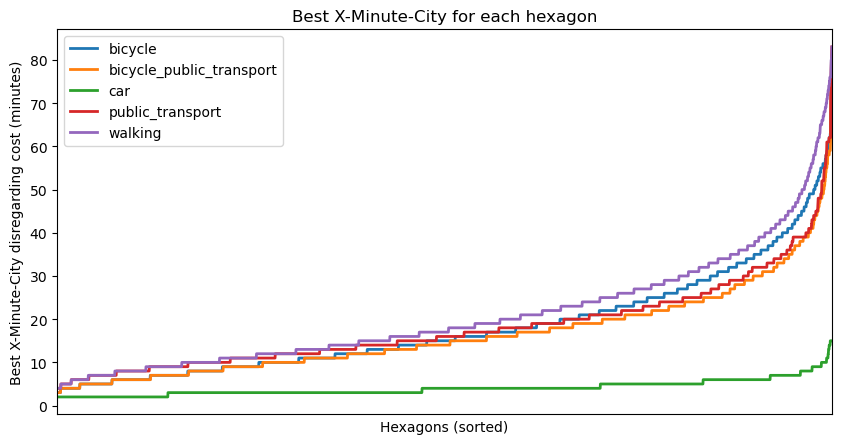

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_sorted_grouped_data(profiles_df, "scenario", "optimal_in_minutes", ax)
ax.set_title('Best X-Minute-City for each hexagon')
ax.set_ylabel('Best X-Minute-City disregarding cost (minutes)')
ax.set_xlabel('Hexagons (sorted)')
plt.show()

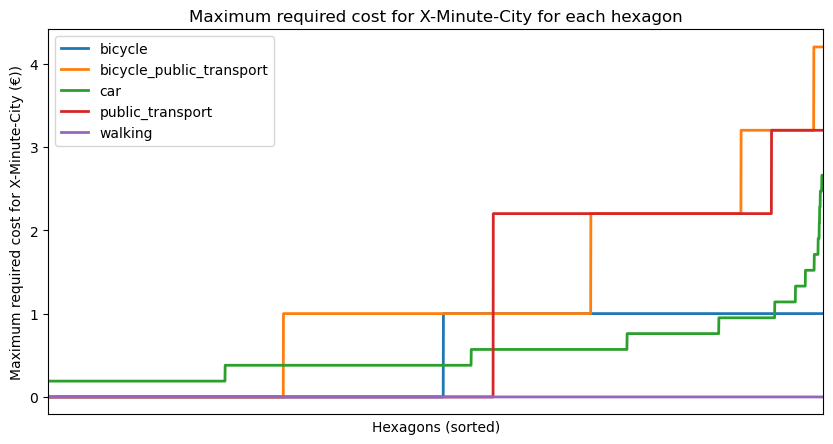

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_sorted_grouped_data(
    profiles_df, "scenario", "required_cost_for_optimal_in_euro", ax
)
ax.set_title("Maximum required cost for X-Minute-City for each hexagon")
ax.set_ylabel("Maximum required cost for X-Minute-City (€))")
ax.set_xlabel("Hexagons (sorted)")
plt.show()


In [56]:
import numpy as np
no_inf_profiles_df = profiles_df[np.isinf(profiles_df[cost_columns]).sum(axis=1) == 0]
no_inf_profiles_df
# np.isinf(profiles_df[cost_columns]).sum(axis=1)


any_column_different  required_cost_for_optimal  optimal  \
hex_id                                                                      
891fa181003ffff                 False                          0    720.0   
891fa181007ffff                 False                          0    960.0   
891fa18100bffff                 False                          0    720.0   
891fa18100fffff                 False                          0    900.0   
891fa181013ffff                  True                        220    540.0   
...                               ...                        ...      ...   
891fa565b87ffff                  True                        320   2940.0   
891fa565b8fffff                 False                          0   3480.0   
891fa565ba7ffff                  True                        320   2940.0   
891fa565bafffff                 False                          0   3480.0   
891fa565bb3ffff                  True                        320   2880.0   

                                 scenario  required_cost_for_optimal_in_euro  \
hex_id                                                                         
891fa181003ffff          public_transport                                0.0   
891fa181007ffff          public_transport                                0.0   
891fa18100bffff          public_transport                                0.0   
891fa18100fffff          public_transport                                0.0   
891fa181013ffff          public_transport                                2.2   
...                                   ...                                ...   
891fa565b87ffff  bicycle_public_transport                                3.2   
891fa565b8fffff  bicycle_public_transport                                0.0   
891fa565ba7ffff  bicycle_public_transport                                3.2   
891fa565bafffff  bicycle_public_transport                                0.0   
891fa565bb3ffff  bicycle_public_transport                                3.2   

                 optimal_in_minutes  cost_0  cost_19  cost_38  cost_57  ...  \
hex_id                                                                  ...   
891fa181003ffff                12.0   720.0    720.0    720.0    720.0  ...   
891fa181007ffff                16.0   960.0    960.0    960.0    960.0  ...   
891fa18100bffff                12.0   720.0    720.0    720.0    720.0  ...   
891fa18100fffff                15.0   900.0    900.0    900.0    900.0  ...   
891fa181013ffff                 9.0   600.0    600.0    600.0    600.0  ...   
...                             ...     ...      ...      ...      ...  ...   
891fa565b87ffff                49.0  3360.0   3360.0   3360.0   3360.0  ...   
891fa565b8fffff                58.0  3480.0   3480.0   3480.0   3480.0  ...   
891fa565ba7ffff                49.0  3360.0   3360.0   3360.0   3360.0  ...   
891fa565bafffff                58.0  3480.0   3480.0   3480.0   3480.0  ...   
891fa565bb3ffff                48.0  3120.0   3120.0   3120.0   3120.0  ...   

                 cost_171  cost_190  cost_200  cost_209  cost_220  cost_228  \
hex_id                                                                        
891fa181003ffff     720.0     720.0     720.0     720.0     720.0     720.0   
891fa181007ffff     960.0     960.0     960.0     960.0     960.0     960.0   
891fa18100bffff     720.0     720.0     720.0     720.0     720.0     720.0   
891fa18100fffff     900.0     900.0     900.0     900.0     900.0     900.0   
891fa181013ffff     600.0     600.0     600.0     600.0     540.0     540.0   
...                   ...       ...       ...       ...       ...       ...   
891fa565b87ffff    3360.0    3360.0    3360.0    3360.0    3300.0    3300.0   
891fa565b8fffff    3480.0    3480.0    3480.0    3480.0    3480.0    3480.0   
891fa565ba7ffff    3360.0    3360.0    3360.0    3360.0    3300.0    3300.0   
891fa565bafffff    3480.0    3480.0    3480.0    3480.0    3480.0    3480.0  

In [60]:
mean_per_cost_per_scenario = no_inf_profiles_df.groupby("scenario")[cost_columns].mean()
mean_per_cost_per_scenario.columns = [int(column.split("_")[1]) for column in mean_per_cost_per_scenario.columns]

In [58]:
maximum_time = mean_per_cost_per_scenario.T.max(numeric_only=True).max()

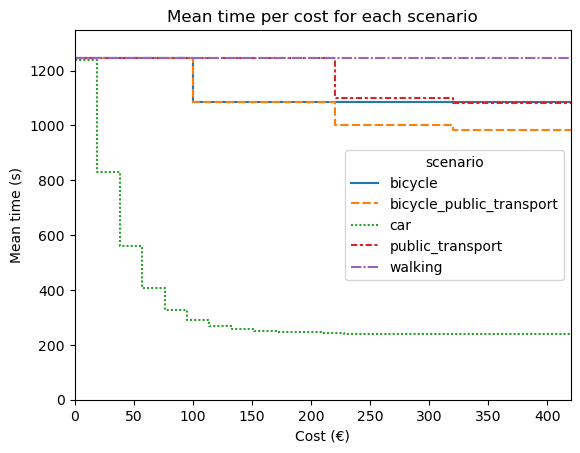

In [70]:
import seaborn as sns
ax = sns.lineplot(data=mean_per_cost_per_scenario.T, drawstyle="steps-post")
# ax = sns.scatterplot(data=mean_per_cost_per_scenario.T)
ax.set_xlim(0, mean_per_cost_per_scenario.T.index.max())
ax.set_ylim(0,maximum_time+100)
ax.set_title("Mean time per cost for each scenario")
ax.set_ylabel("Mean time (s)")
ax.set_xlabel("Cost (€)")
plt.show()

In [61]:
m = folium.Map(location=[50.9375, 6.9603], zoom_start=12)
plot_h3_cells_on_folium(
    profiles_df_per_scenario["bicycle"]["cost_0"].to_dict(),
    m,
    color="red",
    popup_callback=lambda x: strtime.seconds_to_str_time(int(x)),
)
m

In [ ]:
m = folium.Map(location=[50.9375, 6.9603], zoom_start=12)
plot_h3_cells_on_folium(
    profiles_df_per_scenario["car"]["optimal"].to_dict(),
    m,
    color="red",
    popup_callback=lambda x: strtime.seconds_to_str_time(int(x)),
)
m


In [ ]:
m = folium.Map(location=[50.9375, 6.9603], zoom_start=12)
plot_h3_cells_on_folium(
    (profiles_df_per_scenario["car"]["required_cost_for_optimal"]).to_dict(),
    m,
    color="blue",
    popup_callback=lambda x: f"cost: {x/100:.2f}€",
)
m